In [1]:
import pandas as pd
import numpy as np
# from pandas_profiling import ProfileReport
import ipywidgets as widgets
from ipywidgets import interact
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
from sklearn import metrics
from sklearn.decomposition import PCA

In [3]:
def read(path):
    """
    wczytanie danych i usunięcie zbędnych kolumn
    """
    df = pd.read_csv(path)
    df = df.drop(['email', 'phone-number', 'credit_card', 'name'], axis = 1)
    df.loc[(df.hotel == 'City Hotel'), 'hotel'] = 0
    df.loc[(df.hotel == 'Resort Hotel'), 'hotel'] = 1
    return df

In [4]:
df = read(r'C:\Users\User\Desktop\repozytoria\wm_2022\projects\magdas\data\hotel_booking.csv')

Dodać Pandas Profiling + wnioski z niego
przejść na VS Code
optymalizacja parametrów
crossvalidation
lasy losowe
k-nn ???
sieć neuronowa
regresja logistyczna

In [5]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,1,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,1,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,1,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,1,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,1,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


Dane pochodzą ze źródła: https://www.kaggle.com/datasets/mojtaba142/hotel-booking
Kolumny w zbiorze danych:
- hotel - określa hotel, w którym dokonano rezerwacji (tylko dwa hotele)
- is_canceled - czy rezerwacja została anulowana (1) czy nie (0)
- lead_time - ilość dni między złożeniem rezerwacji a dniem przyjazdu
- arrival_date_year 
- arrival_date_month
- arrival_date_week_number
- arrival_date_day_of_month
- stays_in_weekend_nights 
- stays_in_week_nights 
- adults 
- children 
- babies
- meal
- country
- market_segment - TA: Travel Agent, TO - Tour Operators
- distribution_channel
- is_repeated_guest  
- previous_cancellations
- previous_bookings_not_canceled
- reserved_room_type
- assigned_room_type
- booking_changes - ilość zmian
- deposit_type 
- agent
- company
- days_in_waiting_list
- customer_type - Group: gdy rezerwacja jest częścią grupy lub kontraktu lub Transient: gdy rezerwacja nie jest częścią grupy lub kontraktu i nie jest powiązana z inną grupą
- adr - Average Daily Rate: suma wszystkich transakcji noclegowych / łączną liczbę noclegów
- required_car_parking_spaces
- total_of_special_requests
- reservation_status
- reservation_status_date

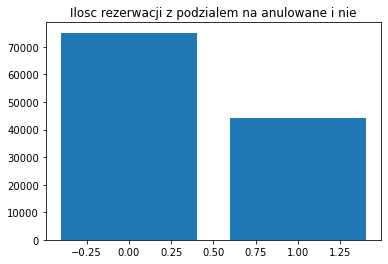

In [6]:
plt.bar([0,1],df['hotel'].groupby(df['is_canceled']).count())
plt.title("Ilosc rezerwacji z podzialem na anulowane i nie")

plt.show()

In [7]:
@interact(kolumna = ['lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 
       'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 
       'days_in_waiting_list', 'adr','required_car_parking_spaces', 'total_of_special_requests'])
def draw_box_plot(kolumna):
    histogram = px.histogram(data_frame=df, x=kolumna, barmode='relative', barnorm=None, histnorm='percent'
             , color_discrete_sequence = ['lightblue']
             , title="Histogram zmiennej " + str(kolumna)
             )
    boxplot = px.box(data_frame=df,y=kolumna,title="Boxplot zmiennej " + str(kolumna) )
    return histogram.show(), boxplot.show()

interactive(children=(Dropdown(description='kolumna', options=('lead_time', 'arrival_date_year', 'arrival_date…

In [8]:
def IQR(dataframe, column):
    q3, q1 = np.nanpercentile(dataframe[column], [75 ,25])
    iqr = q3 - q1
    dataframe.loc[((dataframe[column] > (q3 + iqr)) | (dataframe[column] < (q3 - iqr))), column] = None
    return dataframe

In [9]:
def outliery(dataframe):
    dataframe = IQR(dataframe, 'stays_in_weekend_nights')
    dataframe = IQR(dataframe, 'stays_in_week_nights')
    dataframe.loc[(dataframe['adults'] > 10), 'adults'] = None
    dataframe.loc[(dataframe['children'] > 4), 'children'] = None
    dataframe.loc[(dataframe['babies'] > 3), 'babies'] = None
    dataframe.loc[(dataframe['adr'] > 600), 'adr'] = None
    dataframe = IQR(dataframe, 'adr')
    dataframe.loc[(dataframe['required_car_parking_spaces'] > 3), 'required_car_parking_spaces'] = None
    return dataframe

In [10]:
df_out = outliery(df)

In [11]:
df_out.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights              344
stays_in_week_nights               12498
adults                                12
children                               5
babies                                 2
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [12]:
def braki(dataframe):
    # usuwamy zmienną company, bo mamy 94% braków danych
    dataframe = dataframe.drop(['company'], axis = 1)
    dataframe.loc[(dataframe.agent.isnull()), 'agent'] = 'Brak'
    dataframe.loc[(dataframe.adr.isnull()), 'adr'] = np.mean(dataframe.adr)
    dataframe.loc[(dataframe.stays_in_week_nights.isnull()), 'stays_in_week_nights'] = np.mean(dataframe.stays_in_week_nights)
    dataframe.loc[(dataframe.lead_time.isnull()), 'stays_in_week_nights'] = np.mean(dataframe.lead_time)
    # Usuwamy pozostałe rekordy < 1%
    dataframe = dataframe.dropna()
    return dataframe

In [13]:
df_clear = braki(df_out)

In [14]:
df_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118540 entries, 0 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118540 non-null  object 
 1   is_canceled                     118540 non-null  int64  
 2   lead_time                       118540 non-null  int64  
 3   arrival_date_year               118540 non-null  int64  
 4   arrival_date_month              118540 non-null  object 
 5   arrival_date_week_number        118540 non-null  int64  
 6   arrival_date_day_of_month       118540 non-null  int64  
 7   stays_in_weekend_nights         118540 non-null  float64
 8   stays_in_week_nights            118540 non-null  float64
 9   adults                          118540 non-null  float64
 10  children                        118540 non-null  float64
 11  babies                          118540 non-null  float64
 12  meal            

In [15]:
df_clear = df_clear.drop(['reservation_status_date'], axis = 1)

In [16]:
y = df_clear.is_canceled

In [17]:
X = df_clear.drop(['is_canceled'], axis = 1)

In [18]:
x_all = pd.get_dummies(X)

C:\Users\User\anaconda3\envs\WM\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



In [19]:
x_traina, x_other, y_traina, y_other = train_test_split(x_all,y,
                                              train_size=0.7,
                                              random_state=1234)
x_testa, x_ttesta, y_testa, y_ttesta = train_test_split(x_other,y_other,
                                              train_size=0.6,
                                              random_state=1234)

In [20]:
# Standaryzacja
scaler = preprocessing.StandardScaler()
scaler.fit(x_traina)
x_trainas = scaler.transform(x_traina)
x_testas = scaler.transform(x_testa)

In [21]:
pca_all = PCA()

In [22]:
pca_all.fit(x_trainas)

PCA()

In [23]:
exp_var_pca = pca_all.explained_variance_ratio_
cum_sum = np.cumsum(exp_var_pca)

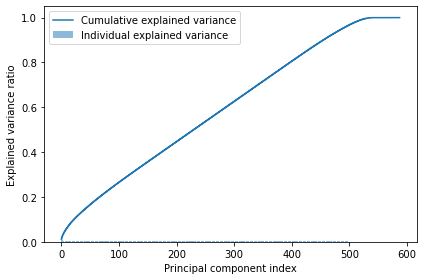

In [24]:
# https://vitalflux.com/pca-explained-variance-concept-python-example/
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum)), cum_sum, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [25]:
pca3 = PCA(n_components=25)
pca3.fit(x_trainas)
x_train3 = pca3.transform(x_trainas)
pca_variance3 = pca3.explained_variance_

In [26]:
var3 = pca3.explained_variance_ratio_
cum_sum3 = np.cumsum(var3)

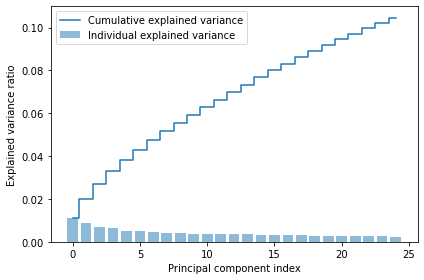

In [27]:
plt.bar(range(0,len(var3)), var3, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum3)), cum_sum3, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [28]:
pca4 = PCA(n_components=10)
pca4.fit(x_trainas)
x_train4 = pca4.transform(x_trainas)

In [29]:
var4 = pca4.explained_variance_ratio_
cum_sum4 = np.cumsum(var4)

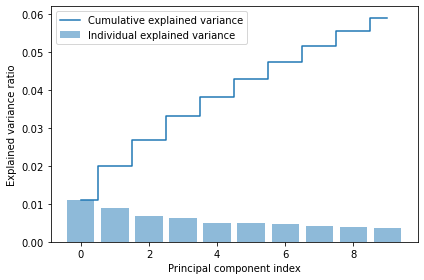

In [30]:
plt.bar(range(0,len(var4)), var4, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum4)), cum_sum4, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Chyba pozostaniemy przy opcji 10 zmiennych.

In [31]:
x_test4 = pca4.transform(x_testas)
x_test3 = pca3.transform(x_testas)

In [32]:
pca2 = PCA(n_components=50)
pca2.fit(x_trainas)
x_train2 = pca2.transform(x_trainas)
x_test2 = pca2.transform(x_testas)

### SVM

In [33]:
clf = svm.SVC(kernel='linear', C=1)
clf.fit(x_train4, y_traina)

SVC(C=1, kernel='linear')

In [34]:
clf3 = svm.SVC(kernel='linear', C=1)

In [35]:
clf3.fit(x_train3, y_traina)

SVC(C=1, kernel='linear')

In [36]:
print(clf.score(x_train4, y_traina))
print(clf.score(x_test4 , y_testa))

0.9671479187254453
0.9697239536954586


In [37]:
def metrics_score(model, x, y, name):
    y_pred = model.predict(x)
    score = {"Name" : name,
        "R2_score": metrics.r2_score(y, y_pred),
     "Accuracy": metrics.accuracy_score(y, y_pred),
     "Precision": metrics.precision_score(y, y_pred),
     "Recall": metrics.recall_score(y, y_pred)}
    return score

In [38]:
metric = pd.DataFrame(columns = ['Name','R2_score', 'Accuracy', 'Precision', 'Recall'])

In [39]:
metric = metric.append(metrics_score(clf, x_train4, y_traina, 'clf_10'), ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_17492\4025968588.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [40]:
metric = metric.append(metrics_score(clf3, x_train3, y_traina, 'clf_25'), ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_17492\3348685123.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [41]:
metric

,Name,R2_score,Accuracy,Precision,Recall
0,clf_10,0.859242,0.967148,0.969649,0.940934
1,clf_25,0.980792,0.995517,0.995118,0.992791


In [42]:
clf2 = svm.SVC(kernel='linear', C=1)
clf2.fit(x_train2, y_traina)

SVC(C=1, kernel='linear')

In [43]:
metric = metric.append(metrics_score(clf2, x_train2, y_traina, 'clf_50'), ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_17492\788949275.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [44]:
metric

,Name,R2_score,Accuracy,Precision,Recall
0,clf_10,0.859242,0.967148,0.969649,0.940934
1,clf_25,0.980792,0.995517,0.995118,0.992791
2,clf_50,0.991429,0.997999,0.997563,0.997045


In [45]:
metric = metric.append(metrics_score(clf, x_test4, y_testa, 'clf_10_val'), ignore_index=True)
metric = metric.append(metrics_score(clf3, x_test3, y_testa, 'clf_25_val'), ignore_index=True)
metric = metric.append(metrics_score(clf2, x_test2, y_testa, 'clf_50_val'), ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_17492\2112394314.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\User\AppData\Local\Temp\ipykernel_17492\2112394314.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\User\AppData\Local\Temp\ipykernel_17492\2112394314.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [46]:
metric

,Name,R2_score,Accuracy,Precision,Recall
0,clf_10,0.859242,0.967148,0.969649,0.940934
1,clf_25,0.980792,0.995517,0.995118,0.992791
2,clf_50,0.991429,0.997999,0.997563,0.997045
3,clf_10_val,0.869871,0.969724,0.969291,0.947831
4,clf_25_val,0.979856,0.995313,0.995276,0.991984
5,clf_50_val,0.991137,0.997938,0.997201,0.997201


### Drzewa decyzyjne

In [47]:
tree = DecisionTreeClassifier()

In [48]:
tree.fit(x_train4, y_traina)

DecisionTreeClassifier()

In [49]:
predictions = tree.predict(x_test4)
print(accuracy_score(y_testa, predictions))

0.9852837793504241


In [50]:
# Wcześniejsze - bez pca = 0.77999226686...
# tree.score(pca_val, y_val)

Sprawdzenie odpowiednich parametrów

In [51]:
params = {
    'criterion':  ['gini', 'entropy'],
    'max_depth':  [10, 15, 20, None],
    'max_features': [None, 0.8]
}

In [52]:
tree_grid = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params,
    cv=5,
    verbose=1,
)

In [53]:
tree_grid.fit(x_train4, y_traina)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20, None],
                         'max_features': [None, 0.8]},
             verbose=1)

In [54]:
tree_grid.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 0.8,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [55]:
metric = metric.append(metrics_score(tree_grid, x_train4, y_traina, 'tree_10'), ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_17492\3423311907.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [56]:
tree3 = DecisionTreeClassifier(ccp_alpha= 0.0,
 class_weight= None,
criterion= 'entropy',
 max_depth= 15,
 max_features= None,
 max_leaf_nodes= None,
 min_impurity_decrease= 0.0,
 min_samples_leaf= 1,
 min_samples_split= 2,
 min_weight_fraction_leaf= 0.0,
 random_state= None,
 splitter= 'best')
tree3.fit(x_train3, y_traina)
metric = metric.append(metrics_score(tree3, x_train3, y_traina, 'tree_25'), ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_17492\1249214309.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [57]:
metric

,Name,R2_score,Accuracy,Precision,Recall
0,clf_10,0.859242,0.967148,0.969649,0.940934
1,clf_25,0.980792,0.995517,0.995118,0.992791
2,clf_50,0.991429,0.997999,0.997563,0.997045
3,clf_10_val,0.869871,0.969724,0.969291,0.947831
4,clf_25_val,0.979856,0.995313,0.995276,0.991984
5,clf_50_val,0.991137,0.997938,0.997201,0.997201
6,tree_10,1.0,1.0,1.0,1.0
7,tree_25,0.999793,0.999952,0.999935,0.999935


In [58]:
tree2 = DecisionTreeClassifier(ccp_alpha= 0.0,
 class_weight= None,
criterion= 'entropy',
 max_depth= 15,
 max_features= None,
 max_leaf_nodes= None,
 min_impurity_decrease= 0.0,
 min_samples_leaf= 1,
 min_samples_split= 2,
 min_weight_fraction_leaf= 0.0,
 random_state= None,
 splitter= 'best')
tree2.fit(x_train2, y_traina)
metric = metric.append(metrics_score(tree2, x_train2, y_traina, 'tree_50'), ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_17492\385701488.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [59]:
metric

,Name,R2_score,Accuracy,Precision,Recall
0,clf_10,0.859242,0.967148,0.969649,0.940934
1,clf_25,0.980792,0.995517,0.995118,0.992791
2,clf_50,0.991429,0.997999,0.997563,0.997045
3,clf_10_val,0.869871,0.969724,0.969291,0.947831
4,clf_25_val,0.979856,0.995313,0.995276,0.991984
5,clf_50_val,0.991137,0.997938,0.997201,0.997201
6,tree_10,1.0,1.0,1.0,1.0
7,tree_25,0.999793,0.999952,0.999935,0.999935
8,tree_50,0.999948,0.999988,1.0,0.999968


In [60]:
metric = metric.append(metrics_score(tree_grid, x_test4, y_testa, 'tree_10_val'), ignore_index=True)
metric = metric.append(metrics_score(tree3, x_test3, y_testa, 'tree_25_val'), ignore_index=True)
metric = metric.append(metrics_score(tree2, x_test2, y_testa, 'tree_50_val'), ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_17492\1436340332.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\User\AppData\Local\Temp\ipykernel_17492\1436340332.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\User\AppData\Local\Temp\ipykernel_17492\1436340332.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [61]:
metric

,Name,R2_score,Accuracy,Precision,Recall
0,clf_10,0.859242,0.967148,0.969649,0.940934
1,clf_25,0.980792,0.995517,0.995118,0.992791
2,clf_50,0.991429,0.997999,0.997563,0.997045
3,clf_10_val,0.869871,0.969724,0.969291,0.947831
4,clf_25_val,0.979856,0.995313,0.995276,0.991984
5,clf_50_val,0.991137,0.997938,0.997201,0.997201
6,tree_10,1.0,1.0,1.0,1.0
7,tree_25,0.999793,0.999952,0.999935,0.999935
8,tree_50,0.999948,0.999988,1.0,0.999968
9,tree_10_val,0.940173,0.986081,0.980676,0.98155


### Regresja logistyczna

In [62]:
from sklearn.linear_model import LogisticRegression

In [63]:
logisticRegr = LogisticRegression(solver = 'lbfgs')

In [64]:
logisticRegr.fit(x_train4, y_traina)

LogisticRegression()

In [65]:
metric = metric.append(metrics_score(logisticRegr, x_train4, y_traina, 'LogReg_10'), ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_17492\1185599655.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [66]:
metric

,Name,R2_score,Accuracy,Precision,Recall
0,clf_10,0.859242,0.967148,0.969649,0.940934
1,clf_25,0.980792,0.995517,0.995118,0.992791
2,clf_50,0.991429,0.997999,0.997563,0.997045
3,clf_10_val,0.869871,0.969724,0.969291,0.947831
4,clf_25_val,0.979856,0.995313,0.995276,0.991984
5,clf_50_val,0.991137,0.997938,0.997201,0.997201
6,tree_10,1.0,1.0,1.0,1.0
7,tree_25,0.999793,0.999952,0.999935,0.999935
8,tree_50,0.999948,0.999988,1.0,0.999968
9,tree_10_val,0.940173,0.986081,0.980676,0.98155


In [67]:
lr2 = LogisticRegression(solver = 'lbfgs')
lr2.fit(x_train2, y_traina)
metric = metric.append(metrics_score(lr2, x_train2, y_traina, 'LogReg_50'), ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_17492\3242914070.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [68]:
lr3 = LogisticRegression(solver = 'lbfgs')
lr3.fit(x_train3, y_traina)
metric = metric.append(metrics_score(lr3, x_train3, y_traina, 'LogReg_25'), ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_17492\1699710356.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [69]:
metric

,Name,R2_score,Accuracy,Precision,Recall
0,clf_10,0.859242,0.967148,0.969649,0.940934
1,clf_25,0.980792,0.995517,0.995118,0.992791
2,clf_50,0.991429,0.997999,0.997563,0.997045
3,clf_10_val,0.869871,0.969724,0.969291,0.947831
4,clf_25_val,0.979856,0.995313,0.995276,0.991984
5,clf_50_val,0.991137,0.997938,0.997201,0.997201
6,tree_10,1.0,1.0,1.0,1.0
7,tree_25,0.999793,0.999952,0.999935,0.999935
8,tree_50,0.999948,0.999988,1.0,0.999968
9,tree_10_val,0.940173,0.986081,0.980676,0.98155


In [70]:
metric = metric.append(metrics_score(logisticRegr, x_test4, y_testa, 'LogReg_10_val'), ignore_index=True)
metric = metric.append(metrics_score(lr2, x_test2, y_testa, 'LogReg_50_val'), ignore_index=True)
metric = metric.append(metrics_score(lr3, x_test3, y_testa, 'LogReg_25_val'), ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_17492\2507942424.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\User\AppData\Local\Temp\ipykernel_17492\2507942424.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\User\AppData\Local\Temp\ipykernel_17492\2507942424.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [71]:
metric

,Name,R2_score,Accuracy,Precision,Recall
0,clf_10,0.859242,0.967148,0.969649,0.940934
1,clf_25,0.980792,0.995517,0.995118,0.992791
2,clf_50,0.991429,0.997999,0.997563,0.997045
3,clf_10_val,0.869871,0.969724,0.969291,0.947831
4,clf_25_val,0.979856,0.995313,0.995276,0.991984
5,clf_50_val,0.991137,0.997938,0.997201,0.997201
6,tree_10,1.0,1.0,1.0,1.0
7,tree_25,0.999793,0.999952,0.999935,0.999935
8,tree_50,0.999948,0.999988,1.0,0.999968
9,tree_10_val,0.940173,0.986081,0.980676,0.98155


In [72]:
metric = metric.append(metrics_score(clf2, x_test2, y_testa, 'clf_50_test'), ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_17492\3518246734.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [73]:
metric

,Name,R2_score,Accuracy,Precision,Recall
0,clf_10,0.859242,0.967148,0.969649,0.940934
1,clf_25,0.980792,0.995517,0.995118,0.992791
2,clf_50,0.991429,0.997999,0.997563,0.997045
3,clf_10_val,0.869871,0.969724,0.969291,0.947831
4,clf_25_val,0.979856,0.995313,0.995276,0.991984
5,clf_50_val,0.991137,0.997938,0.997201,0.997201
6,tree_10,1.0,1.0,1.0,1.0
7,tree_25,0.999793,0.999952,0.999935,0.999935
8,tree_50,0.999948,0.999988,1.0,0.999968
9,tree_10_val,0.940173,0.986081,0.980676,0.98155
